# Derin Öğrenme Yöntemlerinden Evrişimsel Sinir Ağları (CNN) ile Rakam Tanıma 

Bu projede Derin Öğrenme algoritmalarında sıkça kullanılmakta olan Evrişimsel Sinir Ağları (CNN) ile Mnist verisi üzerinde **Rakam Tanıma** projesini gerçekleştiriyor olacağız.

## Amaç Nedir ?

Bu projede amacımız, on binlerce el yazısıyla yazılmış görselden oluşan bir veri kümesindeki rakamları doğru bir şekilde tanımlamaktır.

## Veri Seti Hakkında

MNIST ("Modified National Institute of Standards and Technology"), derin öğrenmenin fiilen "merhaba dünya" veri kümesidir. 1999'da piyasaya sürüldüğünden bu yana, el yazısı görüntülerden oluşan bu klasik veri kümesi, sınıflandırma algoritmalarını karşılaştırmak için oluşturulmuştur.

Mnist datası el yazısıyla yazılmış rakamların görüntülerinden oluşan bir veri setidir. Bu veri setinde yer alan görüntüler 0-9 arasında yer alan rakamlardan ve 28*28 pixel boyutlarında tek kanallı (gri) görüntülerden oluşmaktadır. Veri seti 60000 eğitim, 10000 test olmak üzere toplam 70000 adet görüntüden oluşmaktadır.  

Veri seti hakkında daha fazla bilgi için: http://yann.lecun.com/exdb/mnist/index.html ziyaret edebilirsiniz.

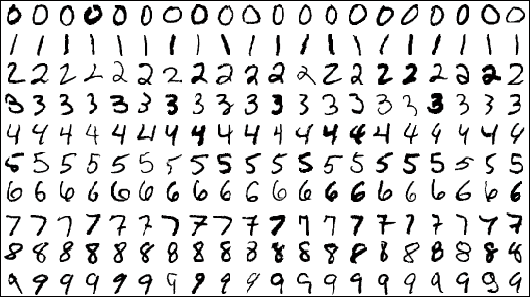

# 1) Gerekli Kütüphanelerin İmport İşlemleri

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.utils import to_categorical, plot_model
from keras. layers import Conv2D, MaxPooling2D
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning)
filterwarnings('ignore')

# 2) Veri Setini Yüklenmesi ve Boyutu İncelenmesi

In [2]:
# Mnist veri seti keras küütphanesi içerisinde tanımlı olan veri setlerinden birisidir. 
# Mnist veri setinin yüklenmesi
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Eğitim Seti Boyutu:", x_train.shape, y_train.shape ,"Test Seti Boyutu:", x_test.shape, y_test.shape)

# Bağımlı değişkendeki etiket sayısının hesaplanması. Burada 0-9 arasında rakamlar olduğu için 10 sınıf bulunmaktadır.
num_labels = len(np.unique(y_train))
print("Sınıf Sayısı:" ,num_labels)

11493376/11490434 [==============================] - 0s 0us/step
Eğitim Seti Boyutu: (60000, 28, 28) (60000,) Test Seti Boyutu: (10000, 28, 28) (10000,)
Sınıf Sayısı: 10


# 3) Veri Setinden Örnekler Gösterilmesi

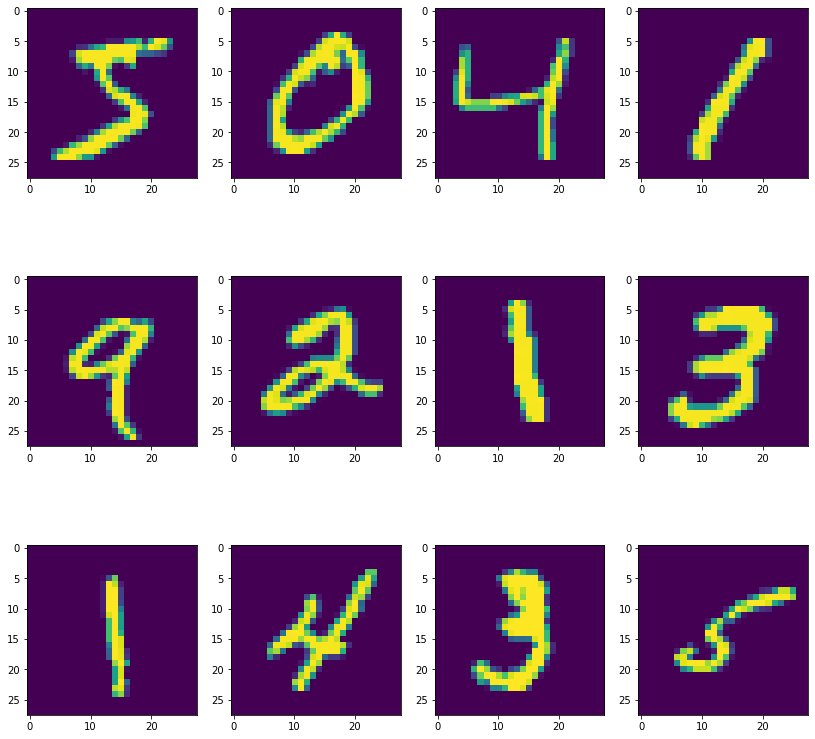

In [3]:
plt.figure(figsize=(14,14))
x, y = 4,3
for i in range(12):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i])
plt.show()

# 4) Standardizasyon ve One Hot Encoding İşlemleri 

One Hot Encoding yapma sebebimiz y bağımlı değişken olduğu için benim etiket (Label) değerimi temsil etmektedir. Bu değer hali hazırda 0 ve 9 arasındaki değerlerden oluşmaktadır. Ben burada One Hot Encoding işlemi yaparak label değerimi 0-1 arasına çekmekteyim. Bunu yaparak ilgili sayı değeri 1 olacak diğerleri 0 olacak. Bu çok sınıflı (0-9) bir sınıflandırma problemi olduğundan, bu, sınıf vektörlerini ikili sınıf matrislerine dönüştürecektir. Örneğin, rakamın 2 olduğunu varsayalım, vektörü [0 1 2 3 4 5 6 7 8 9] 'dan [0 0 1 0 0 0 0 0 0]' a çevireceğiz.

In [4]:
# One Hot Encoding İşlemi
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Girdi görüntüsünün boyutları
image_size = x_train.shape[1]

# reshape işlemi gerçekleştirilmesi
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])

# Ayrıca 0 ile 255 arasındaki gri skaladaki piksel değerlerini 0 ile 1 arasında normalize edeceğiz. Bunu her birini 255'e bölerek yapıyoruz.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# 5) Modelin Oluşturulması

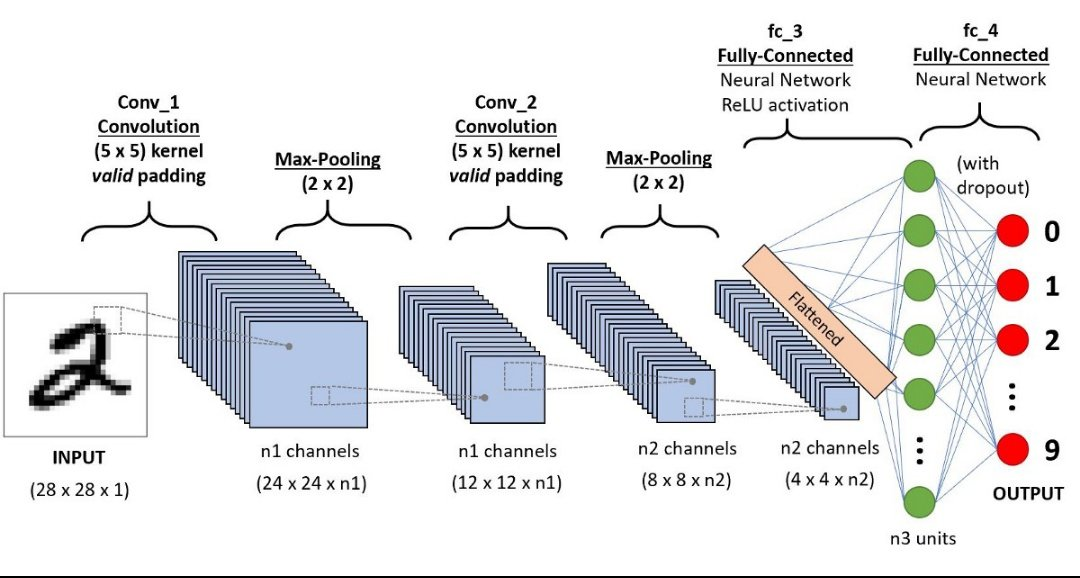

In [5]:
# Hiperparamtrelerin Ayarlanması

# Giriş görüntüsünün boyutları (28, 28, 1) belirtilmektedir.
input_shape = (image_size, image_size, 1)

# Her bir epochda (dönemde) veri setinden alınacak olan kümenin eleman sayısı belirlenir.
batch_size = 128 

# Modelin kaç dönemde (epochs) eğitilmesi gerektiği ile ilgili hiperparametredir. 
epochs = 10 # 12 epoch önerilir

# Filtre Boyutu 3 x 3 olacak şekilde ayarlanmıştır.
kernel_size = 3

# Ortaklama (Pooling) Boyutu 2 x 2 olacak şekilde ayarlanmıştır. 
pool_size = 2

# Kaç adet filtre olacağı bilgisi ayarlanmıştır. 64 adet filtre olacaktır. 
filters = 64

# Seyreltme oranı ayarlanmıştır.
dropout = 0.2

In [6]:
# Model Katmanlarının Oluşturulması 5 Katmandan oluşmaktadır. 
model = Sequential()

#1.KATMAN
model.add(Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size))

#2.KATMAN
model.add(Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 activation='relu'))
model.add(MaxPooling2D(pool_size))

#3.KATMAN
model.add(Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 activation='relu'))

# TAM BAĞLANTI KATMANI
model.add(Flatten())

# ÇIKIŞ KATMANI
model.add(Dropout(dropout))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [7]:
# Model özeti
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dropout (Dropout)            (None, 576)               0

In [8]:
# Optimizasyon ve Değerlendirme metrikleri ayarlanmaktadır.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 41s 87ms/step - loss: 0.2714 - accuracy: 0.9156 - val_loss: 0.0631 - val_accuracy: 0.9803
Epoch 2/10
469/469 [==============================] - 40s 85ms/step - loss: 0.0711 - accuracy: 0.9779 - val_loss: 0.0403 - val_accuracy: 0.9872
Epoch 3/10
469/469 [==============================] - 39s 84ms/step - loss: 0.0497 - accuracy: 0.9846 - val_loss: 0.0368 - val_accuracy: 0.9877
Epoch 4/10
469/469 [==============================] - 40s 85ms/step - loss: 0.0397 - accuracy: 0.9875 - val_loss: 0.0299 - val_accuracy: 0.9896
Epoch 5/10
469/469 [==============================] - 40s 84ms/step - loss: 0.0334 - accuracy: 0.9894 - val_loss: 0.0279 - val_accuracy: 0.9906
Epoch 6/10
469/469 [==============================] - 40s 84ms/step - loss: 0.0265 - accuracy: 0.9916 - val_loss: 0.0233 - val_accuracy: 0.9924
Epoch 7/10
469/469 [==============================] - 40s 85ms/step - loss: 0.0244 - accuracy: 0.9922 - val_loss: 0.0226 - val_accuracy:

# 6) Accuracy ve Loss Grafiklerinin Çizdirilmesi

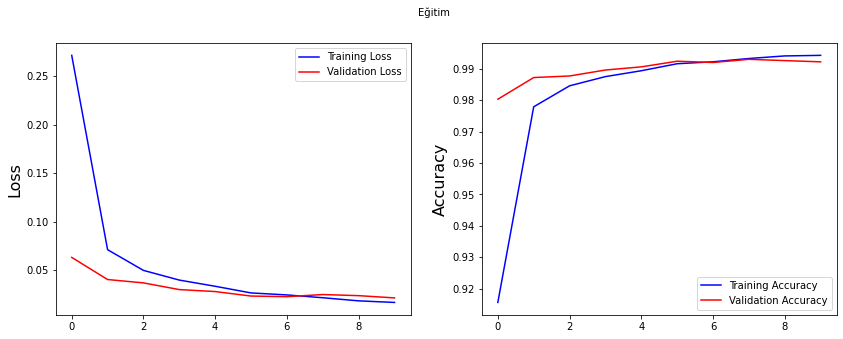

In [28]:
plt.figure(figsize=(14,5))

# Loss
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# Accuracy
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# 7) Modelin Kaydedilmesi

In [10]:
# h5 dosyası olarak kaydetmek 
model.save('mnist_model.h5')

In [11]:
# json formatında kaydetmek
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

# 8) Model Başarı Değerlendirme

In [12]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))

79/79 [==============================] - 2s 21ms/step - loss: 0.0214 - accuracy: 0.9922

Test accuracy: 99.2%

Test loss: 2.1%


# 9) Modelin Test Edilmesi

In [13]:
# x_test içerisinden rastgele bir değer seçilir.
# Seçilen bu değerin label kısmındaki vektörüne bakılır. 1 olan değer bizim değerimizdir.
test_image = x_test[25]
y_test[25]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

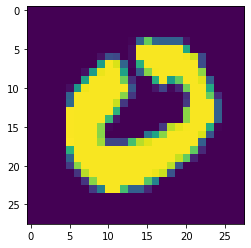

In [19]:
# Seçmiş olduğumuz rastgele bu rakam görselleştirilir.
plt.imshow(test_image.reshape(28,28));

In [15]:
# Rastgele seçilen bu değer modele sorulur.
# Burada modelin tahmin ettiği rakam ve olasılık değerleri yazdırılmaktadır. Olasılık değeri 1'e en yakın olan değer yukarıdaki labeldaki index sıralaması aynı olmalıdır.
test_data = x_test[25].reshape(1,28,28,1)
preds = model.predict_classes(test_data)
proba = model.predict_proba(test_data)
print(preds, proba)

[0] [[9.9988210e-01 1.9396307e-10 2.5931664e-05 2.9538796e-10 4.5367098e-05
  3.5744236e-08 1.3966028e-06 1.4436469e-06 1.1114186e-05 3.2682241e-05]]


# 10) Flask & Heroku Mnist Dataset Model Deployment

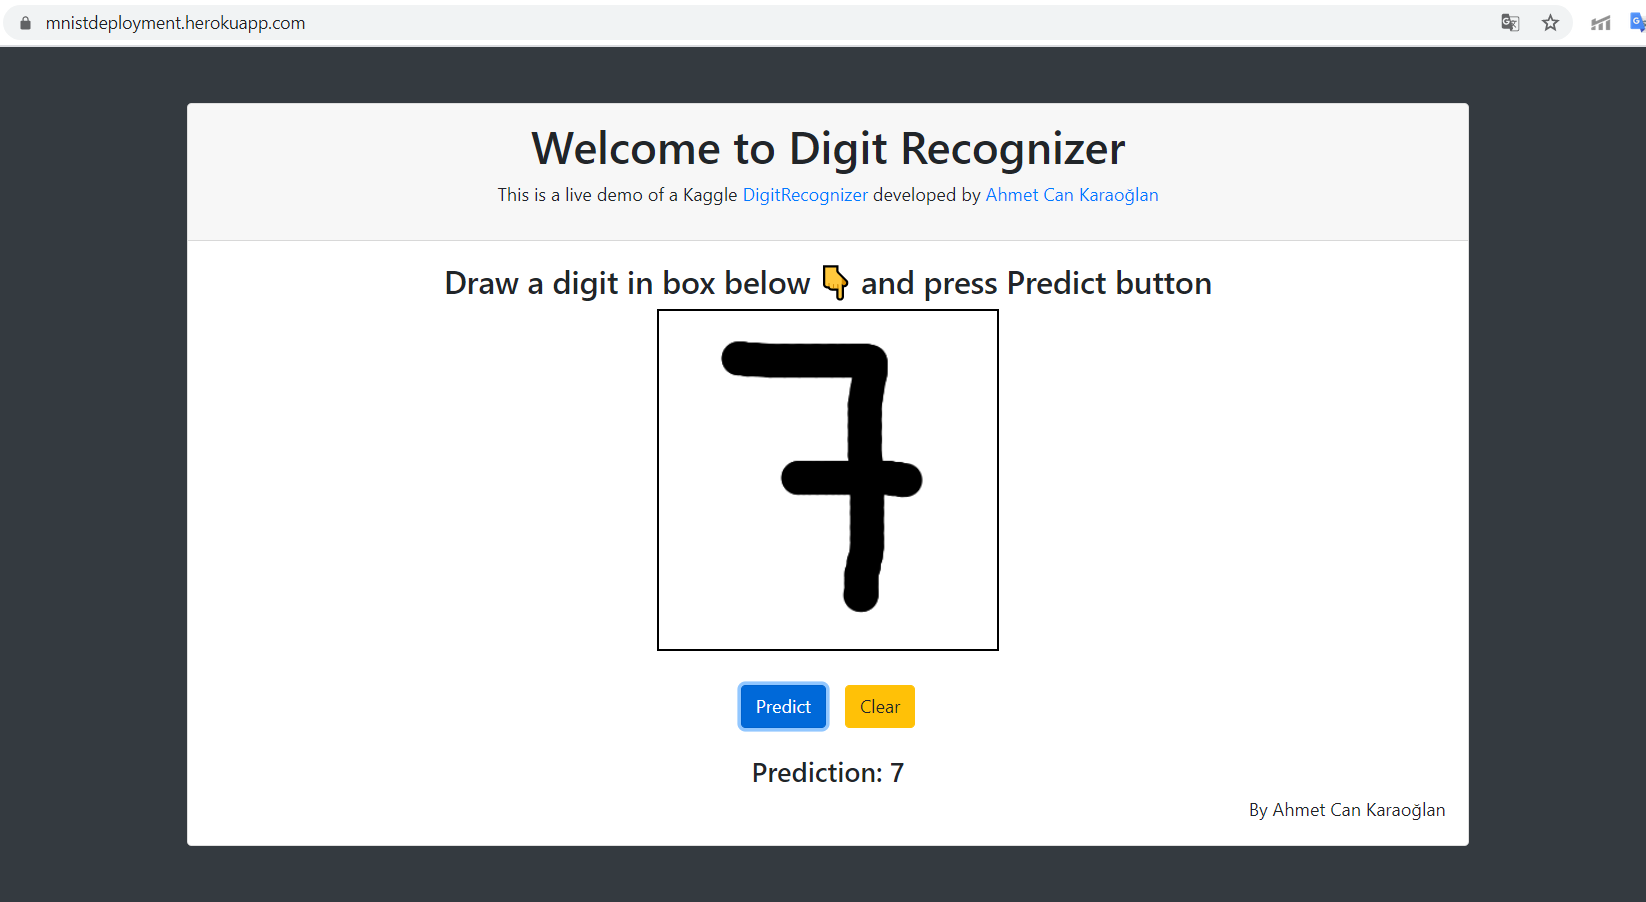

## Proje Linki (*Heroku* ile Deploy edildi):

**https://mnistdeployment.herokuapp.com/**

### Gereklilikler

İlgili **[Repo](https://github.com/ahmetcankaraoglan/Mnist-Model-Deployment)**'yu olduğu gibi kopyalamanız veya forklamanız gerekmektedir.

### Projeyi Heroku'dan Çalıştırmak için:

1. Repo olduğu gibi kopyalanarak yeni bir repo oluşturulur. Örneğin Mnist-Prediction isimli bir repo veya forklayarak direk devam edebilirsiniz.
2. **[Heroku](https://www.heroku.com/)** 'dan hesap açılır.
3. Create New App bölümünden yeni bir uygulama açılır ve isimlendirilir.
4. Deploy bölümünde yer alan "Deployment Method" bölümünden Github seçilir.
5. Mnist-Prediction isminde Github'ta yer alan repo ile eşleştirme yapılır.
6. Manual Deploy diyerek model deploy edilir.

### Model Deployment Çalıştırma

İlk tahmin işlemi için için tahmin süresi 20 saniye kadar sürebilir (Bunun sebebi model yüklendiği içindir). Ancak daha sonra tahmin süresi büyük ölçüde azalmaktadır.


